<a href="https://colab.research.google.com/github/RMSCRV/IB2AD/blob/main/Assignment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving credit_data.csv to credit_data.csv


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('credit_data.csv')

y_value = df['class'] # set the y value
y_values = np.ravel(y_value) # changing y to an array (list)

x_values = df.drop('class', axis=1) # drop the y from the dataframe

# splitting the data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_values, test_size = 0.2, random_state = 4567, stratify=y_values)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(800, 20)
(200, 20)
(800,)
(200,)


In [ ]:
display(df.head())
display(df.dtypes)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


,0
checking_status,object
duration,int64
credit_history,object
purpose,object
credit_amount,int64
savings_status,object
employment,object
installment_commitment,int64
personal_status,object
other_parties,object


In [ ]:
non_numeric = X_train.select_dtypes(include=['object'])
print(non_numeric.columns)
print(non_numeric.head())

Index(['checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'job', 'own_telephone',
       'foreign_worker'],
      dtype='object')
    checking_status credit_history              purpose savings_status  \
576        0<=X<200  existing paid             radio/tv           <100   
642     no checking  existing paid            education     100<=X<500   
743              <0       all paid  furniture/equipment    500<=X<1000   
927              <0  existing paid             used car           <100   
821           >=200  existing paid             radio/tv           <100   

    employment     personal_status other_parties property_magnitude  \
576     4<=X<7  female div/dep/mar          none        real estate   
642     1<=X<4         male single          none     life insurance   
743     1<=X<4         male single          none        real estate   
927   

In [ ]:
import re
def parse_range(value):
    if isinstance(value, str):
        match = re.findall(r'[\d.]+', value)
        if len(match) == 2:
            low, high = map(float, match)
            return (low + high) / 2
        elif len(match) == 1:
            return float(match[0])
    return np.nan

In [ ]:
for col in non_numeric.columns:
    X_train[col] = X_train[col].apply(parse_range)
    X_test[col] = X_test[col].apply(parse_range)

In [ ]:
# Modeling and Evaluation
# We set up a Logistic Regression and New Models
# Initially we set all models up with their default hyperparameters and then compare the results

from sklearn.linear_model import LogisticRegression as LogR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from xgboost import XGBClassifier as XGB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Identify categorical columns (these were previously converted to float with NaNs)
# Based on the dtypes output, these are the columns that should be treated as categorical:
categorical_features = ['checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'job', 'own_telephone',
       'foreign_worker']

# Before applying the pipeline, convert these columns back to object dtype
# This is necessary because the parse_range function might have converted them to float with NaNs,
# and the OneHotEncoder expects object or category dtype for categorical features.
for col in categorical_features:
    # We use .fillna(np.nan).astype(object) to ensure that actual NaNs are preserved as NaNs of object dtype
    # before the OneHotEncoder's handle_unknown='ignore' or other strategies are applied within the pipeline.
    if col in X_train.columns:
      X_train[col] = X_train[col].astype(object)
    if col in X_test.columns:
      X_test[col] = X_test[col].astype(object)

# Convert target variable to numerical labels
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


# Create a column transformer with OneHotEncoder and StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), X_train.select_dtypes(include=np.number).columns.tolist()) # Scale numerical features
    ],
    remainder='passthrough' # Keep other columns
)


# Create pipelines for each model including the preprocessor
# Increased max_iter and added StandardScaler for Logistic Regression
LogR_algo = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogR(max_iter=5000))])
RF_algo = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RF(random_state=4567))])
GBDT_algo = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GBDT(random_state=4567))])
# Removed use_label_encoder from XGBoost
XGB_algo = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGB(eval_metric='logloss', random_state=4567))])

# Fit the pipelines using the encoded target variable
LogR_model = LogR_algo.fit(X_train, Y_train_encoded)
RF_model = RF_algo.fit(X_train, Y_train_encoded)
GBDT_model = GBDT_algo.fit(X_train, Y_train_encoded)
XGB_model = XGB_algo.fit(X_train, Y_train_encoded)

models = [LogR_model, RF_model, GBDT_model, XGB_model]
names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']

for i in range(4):
  print(f'Model: {names[i]}')

  # predict bases on training data
  predict = models[i].predict(X_train)

  # Calculate precision, recall, F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train_encoded, predict, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-score: {f1_score}')
  print('\n')

Model: Logistic Regression
Precision: 0.69140625
Recall: 0.6458333333333333
F1-score: 0.6566666666666667


Model: Random Forest
Precision: 1.0
Recall: 1.0
F1-score: 1.0


Model: Gradient Boosting
Precision: 0.8669219989855483
Recall: 0.8175595238095238
F1-score: 0.8364556931877047


Model: XGBoost
Precision: 1.0
Recall: 1.0
F1-score: 1.0




In [ ]:
# Tune the hyperparameters, and see the scores again

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# supressing the warnings
import warnings
warnings.filterwarnings('ignore')

# creating a hyperparameter search function for re-usability
def random_search(algo, hyperparameters, X_train, Y_train):
  # do the search using 5 folds/chunks
  # Use the pipeline as the estimator for RandomizedSearchCV
  clf = RandomizedSearchCV(algo, hyperparameters, cv = 5, random_state = 2015,
                           scoring = 'precision_macro', n_iter = 20, refit = True)
  clf.fit(X_train, Y_train)
  return clf.best_params_

# Logistic Regression
LogR_tuned_parameters = {
    # Prefix hyperparameters with the step name 'classifier__'
    'classifier__solver': ['liblinear'], # does both L1 and L2
    # C is the equivalent of alpha in L1/L2 regression - level of regularization
    'classifier__C': uniform(loc=0.1, scale=19.9), # drawing from a uniform dist.
    'classifier__penalty': ['l1', 'l2'] # elasticnet and None are not valid for liblinear
}

# Pass the LogR_algo pipeline to the random_search function
LogR_best_params = random_search(LogR_algo, LogR_tuned_parameters, X_train, Y_train_encoded)

# Random Forest
RF_tuned_parameters = {
    # Prefix hyperparameters with the step name 'classifier__'
    'classifier__n_estimators': randint(50,500),
    'classifier__max_depth': randint(2,7),
    'classifier__min_samples_split': randint(2,7),
    'classifier__max_features': ['sqrt', 'log2', None]
}

# Pass the RF_algo pipeline to the random_search function
RF_best_params = random_search(RF_algo, RF_tuned_parameters, X_train, Y_train_encoded)

# Gradient Bosting Decision Trees
GBDT_tuned_parameters = {
    # Prefix hyperparameters with the step name 'classifier__'
    'classifier__n_estimators': randint(25,250),
    'classifier__learning_rate': uniform(loc=0.01, scale=4.99),
    'classifier__criterion': ['friedman_mse', 'squared_error'],
    'classifier__max_depth': randint(2,7)
}

# Pass the GBDT_algo pipeline to the random_search function
GBDT_best_params = random_search(GBDT_algo, GBDT_tuned_parameters, X_train, Y_train_encoded)

# XGBDT
XGB_tuned_parameters = {
    # Prefix hyperparameters with the step name 'classifier__'
    'classifier__n_estimators': randint(25,250),
    # eta is the learning rate
    'classifier__eta': uniform(loc=0.01, scale=4.99),
    # objective is same as criterion
    'classifier__objective': ['binary:logistic', 'binary:hinge'],
    # Corrected typo in max_depth
    'classifier__max_depth': randint(2,7)
}

# Pass the XGB_algo pipeline to the random_search function
# Corrected the algorithm passed to random_search from GBDT_algo to XGB_algo
XGB_best_params = random_search(XGB_algo, XGB_tuned_parameters, X_train, Y_train_encoded)

# Training the models with best parameters
# Set the best parameters on the classifier step of the pipelines
LogR_model = LogR_algo.set_params(**LogR_best_params).fit(X_train, Y_train_encoded)
RF_model = RF_algo.set_params(**RF_best_params).fit(X_train, Y_train_encoded)
GBDT_model = GBDT_algo.set_params(**GBDT_best_params).fit(X_train, Y_train_encoded)
XGB_model = XGB_algo.set_params(**XGB_best_params).fit(X_train, Y_train_encoded)

# Scoring the models
models = [LogR_model, RF_model, GBDT_model, XGB_model]
names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']

for i in range(len(models)):
  print(f'Model: {names[i]}')
  # Predict using the test data for evaluation on unseen data
  predict = models[i].predict(X_test)
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test_encoded, predict, average='macro')

  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-score: {f1_score}')
  print('\n')

Model: Logistic Regression
Precision: 0.671875
Recall: 0.6309523809523809
F1-score: 0.64


Model: Random Forest
Precision: 0.7146558105107328
Recall: 0.5345238095238095
F1-score: 0.4890412800860562


Model: Gradient Boosting
Precision: 0.6897018970189702
Recall: 0.6333333333333333
F1-score: 0.643640350877193


Model: XGBoost
Precision: 0.6381998582565556
Recall: 0.5928571428571429
F1-score: 0.5967181198720624




Random Forest Confusion Matrix


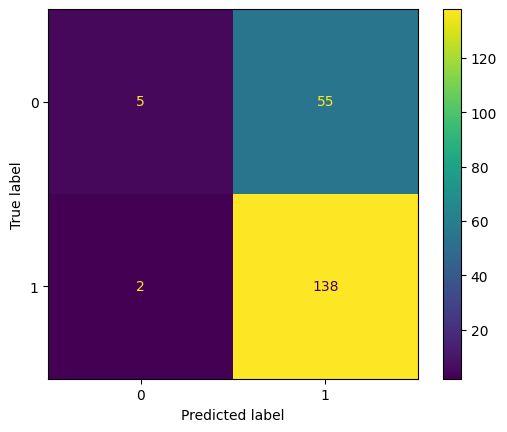

Gradient Boosting Confusion Matrix


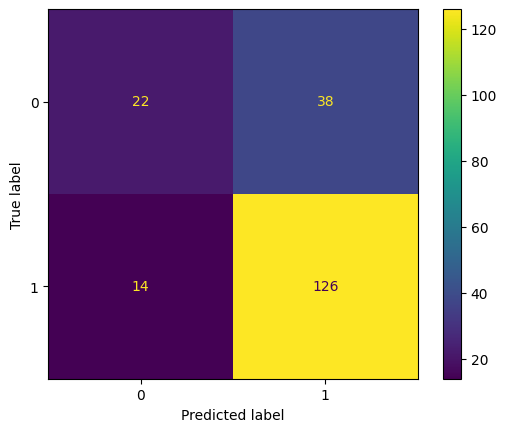

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay as CM
import matplotlib.pyplot as plt

#Random Forest
print('Random Forest Confusion Matrix')
predict = RF_model.predict(X_test)
CM.from_predictions(Y_test_encoded, predict)
plt.show()

# Gradient Boosting
print('Gradient Boosting Confusion Matrix')
predict = GBDT_model.predict(X_test)
CM.from_predictions(Y_test_encoded, predict)
plt.show()